# Creation of maps with the extracted datasets

In [170]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import shapely.wkt
from shapely.geometry import Point, Polygon
import pysal

import re

from scipy import stats

from branca.colormap import linear

import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime, TimeSliderChoropleth
from folium import IFrame

In [171]:
with open('conflict.pickle', 'rb') as data_source:
    conflict_df = pickle.load(data_source)

In [172]:
geometry = conflict_df['geom_wkt'].map(shapely.wkt.loads)
conflict_df = conflict_df.drop('geom_wkt', axis=1)
crs = {'init': 'epsg:4326'}
conflict_gdf = gpd.GeoDataFrame(conflict_df, crs=crs, geometry=geometry)


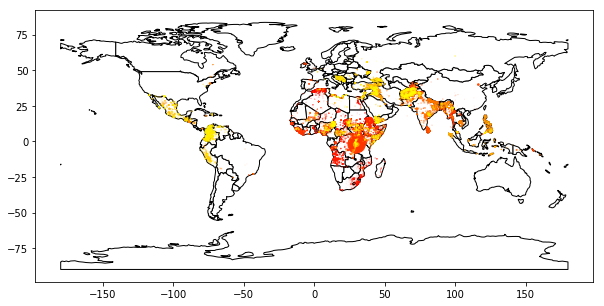

In [173]:
#for row in list(gdf.index.values):
#    print(gdf.get_value(row,"best"))
#    gdf[row].plot(s=gdf.get_value(row, "best"))
#    break
fig, ax = plt.subplots(figsize=(10,5))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


world.plot(ax=ax, color='white', edgecolor='black')
conflict_gdf.plot(ax=ax, markersize=(conflict_gdf.loc[:, "best"]/1000), cmap="autumn")
    
plt.show()

In [174]:
table = """
<!DOCTYPE html>
<html>
<head>
<style>
table {{
    width:100%;
}}
table, th, td {{
    border: 1px solid black;
    border-collapse: collapse;
}}
th, td {{
    padding: 5px;
    text-align: left;
}}
table#t01 tr:nth-child(odd) {{
    background-color: #eee;
}}
table#t01 tr:nth-child(even) {{
   background-color:#fff;
}}
</style>
</head>
<body>

<table id="t01">
  <tr>
    <td>Type</td>
    <td>{}</td>
  </tr>
  <tr>
    <td>Name</td>
    <td>{}</td>
  </tr>
  <tr>
    <td>Nbr</td>
    <td>{}</td>
  </tr>
</table>
</body>
</html>
""".format

In [175]:
m = folium.Map(tiles='cartodbpositron')

In [176]:
#print("Rows to parse:{}".format(len(gdf)))

#width, height = 310,110
#popups, locations = [], []
#for idx, row in tqdm(conflict_gdf.iterrows()):
#    locations.append([row['geometry'].y, row['geometry'].x])
#    name = row['conflict_name'].encode('ascii', 'xmlcharrefreplace')
#    deaths = row['best']
#    iframe = folium.IFrame(table('Deaths', name, deaths), width=width, height=height)
#    popups.append(iframe)


In [177]:
#h = folium.FeatureGroup(name='Deaths')
#h.add_child(FastMarkerCluster(locations))
#m.add_child(h)

In [178]:
#m

## Attempt at creating heatmap layer

In [179]:
with open('country_human_cost.pickle', 'rb') as data_source:
    country_human_cost_df = pickle.load(data_source)

In [180]:
display(conflict_df.head(1))

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,longitude,country,country_id,date_start,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,geometry
0,4,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,44.206667,Yemen (North Yemen),678,2010,2,0,0,0,2,POINT (44.206667 15.354722)


In [181]:
event_list = conflict_df[["latitude", "longitude", "best", "year"]]
display(event_list.head(2))

,latitude,longitude,best,year
0,15.354722,44.206667,2,2010
1,12.779444,45.036667,0,2011


In [182]:
# keep only events w/ deaths
event_list = event_list[event_list.best > 0]

In [183]:
event_list = event_list.sort_values("year")

In [184]:
event_list.sort_values("best", ascending = False)
display(event_list.sort_values("best").head(5))

,latitude,longitude,best,year
51579,19.461476,81.708160,1,2006
59365,6.641599,101.446521,1,2005
786,36.750000,3.666667,1,2005
59363,6.543783,101.251049,1,2005
57926,6.104253,101.893325,1,2005


In [185]:
event_df_array = []
for year in np.sort(event_list.year.unique()):
    print(year, end=", ") #make sure years are in the desired order
    event_df_array.append(event_list[event_list.year == year])

1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 

### Create Heatmap with each events

In [186]:
event_pos_date_array = []
for index in range(len(event_df_array)):
    event_pos_date_array.append([[row.latitude, row.longitude] for row in event_df_array[index].itertuples()])

In [187]:
NBR_OF_EVENT_PER_DATE = 10
smaller_event_pos_date_array = []
for year in range(len(event_pos_date_array)):
    smaller_event_pos_date_array.append([row for index, row in enumerate(event_pos_date_array[year]) \
                                             if index<NBR_OF_EVENT_PER_DATE])

In [188]:
m = folium.Map(tiles='cartodbpositron', world_copy_jump = True, no_wrap=True, zoom_start=8)

In [189]:
index = 0
# TODO: find good gradient color for colorblind that still show the heatmap
for index, year in enumerate(event_list.year.unique()):
    m.add_child(plugins.HeatMap(event_pos_date_array[index],
                                name="{}".format(year),
                                max_val=event_list.best.max(),
                                min_opacity=100,
                                radius=3,
                                blur=10,
                                max_zoom=6,
                                gradient ={0.01: 'blue', 0.03: 'cyan', 0.06: 'green', 0.1: 'yellow', 0.15:'orange', 0.2:'red',  1: 'magenta'}))


In [190]:
folium.LayerControl().add_to(m)
folium.plugins.Fullscreen().add_to(m)
m.save('heatmap_w_time_layered.html')

In [191]:
m = folium.Map(tiles='cartodbpositron', world_copy_jump = True, no_wrap=True, zoom_start=8)

In [192]:
hm = plugins.HeatMapWithTime(data=smaller_event_pos_date_array, index=event_list.year.unique())
hm.add_to(m)

In [193]:
folium.plugins.Fullscreen().add_to(m)
m.save('heatmap_w_time.html')

## Use timestamped geojson

In [194]:
with open('country_human_cost.pickle', 'rb') as data_source:
    country_human_cost_df = pickle.load(data_source)

In [195]:
display(country_human_cost_df.head(5))

number_of_events                         events_id  \
year   country_id                                                       
1989.0 2.0                        0                                 0   
       20.0                       0                                 0   
       31.0                       0                                 0   
       40.0                       0                                []   
       41.0                       4  [186087, 186122, 186123, 186124]   

                   displacement_extern  displacement_intern  \
year   country_id                                             
1989.0 2.0                         0.0                  0.0   
       20.0                        0.0                  0.0   
       31.0                        0.0                  0.0   
       40.0                     7682.0                  0.0   
       41.0                     3344.0                  0.0   

                   total_displacement  deaths           gdp  
year   country_id                                            
1989.0 2.0                        0.0       0  22599.992143  
       20.0                       0.0       0  20700.799311  
       31.0                       0.0       0  14213.543372  
       40.0                    7682.0       0   2577.207019  
       41.0                    3344.0      48    393.347528

In [196]:
# TODO:
# 1) create a timestamped chloropleth with the displacements by country
# 2) create polygons for each conflict that show their area and that are collored depending on the number of deaths
# 3) merge the two

In [197]:
country_codes_df = pd.read_csv("countrycode.csv")
display(country_codes_df.head(5))

,Unnamed: 0,ar5,continent,cowc,cown,eu28,eurocontrol_pru,eurocontrol_statfor,fao,fips105,...,country.name.es,country.name.fr,country.name.ru,country.name.zh,eurostat,wb_api2c,wb_api3c,p4_scode,p4_ccode,wvs
0,1,ASIA,Asia,AFG,700.0,NaN,Asia,Asia/Pacific,2.0,AF,...,Afganistán,Afghanistan,Афганистан,阿富汗,AF,AF,AFG,AFG,700.0,4.0
1,2,OECD1990,Europe,NaN,NaN,NaN,Eurocontrol,ESRA North-West,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,EIT,Europe,ALB,339.0,NaN,Eurocontrol,ESRA East,3.0,AL,...,Albania,Albanie,Албания,阿尔巴尼亚,AL,AL,ALB,ALB,339.0,8.0
3,4,MAF,Africa,ALG,615.0,NaN,Africa,North-Africa,4.0,AG,...,Argelia,Algérie,Алжир,阿尔及利亚,DZ,DZ,DZA,ALG,615.0,12.0
4,5,ASIA,Oceania,NaN,NaN,NaN,Asia,Asia/Pacific,NaN,AQ,...,NaN,NaN,NaN,NaN,AS,AS,ASM,NaN,NaN,16.0


In [198]:
def extract_iso3_from_gnow(gnwo):
    try:
        iso3 = country_codes_df.loc[country_codes_df.cown == gnwo]["wb_api3c"].values[0]
    except IndexError as e:
        # 99 = Great Columbia
        # 711 = Tibet
        # 972 = Tonga
        # 973 = Tuvalu
        if not (gnwo == 99 or gnwo == 711 or gnwo == 971 or gnwo == 972 or gnwo == 973):
            print(e, "with gnwo: {}".format(gnwo))
        return None
    return iso3
print(extract_iso3_from_gnow(2))

USA


In [199]:
def extract_gnwo_countries_to_df():
    """Extract the countries from the gnwo and their id from the gnwo files"""
    countries_list = []
    # First gnwo file, contains id, code, name for all gnow numbers
    with open("gnwo.txt", "r") as gnow:
        for line in gnow:
            split_line = re.split(r'\t+', line)
            countries_list.append(split_line[0:3])
    countries_df = pd.DataFrame(countries_list, columns=["id", "code", "name"])
    countries_df["id"] = pd.to_numeric(countries_df["id"])
    countries_df = countries_df.drop_duplicates()
    return countries_df.set_index("id")
countries_list = extract_gnwo_countries_to_df()
display(countries_list.head(5))

,code,name
id,,
2,USA,United States of America
20,CAN,Canada
31,BHM,Bahamas
40,CUB,Cuba
41,HAI,Haiti


In [200]:
# Add code column to the country_human_cost_df
countries_codes = []
for row in country_human_cost_df.itertuples():
    countries_codes.append([row.Index[0], row.Index[1], extract_iso3_from_gnow(row.Index[1])])
countries_codes = pd.DataFrame(countries_codes, columns=["year", "country_id","country_code"]).set_index(["year", "country_id"])

index 0 is out of bounds for axis 0 with size 0 with gnwo: nan
index 0 is out of bounds for axis 0 with size 0 with gnwo: 340.0
index 0 is out of bounds for axis 0 with size 0 with gnwo: nan
index 0 is out of bounds for axis 0 with size 0 with gnwo: 340.0
index 0 is out of bounds for axis 0 with size 0 with gnwo: nan
index 0 is out of bounds for axis 0 with size 0 with gnwo: 340.0
index 0 is out of bounds for axis 0 with size 0 with gnwo: nan
index 0 is out of bounds for axis 0 with size 0 with gnwo: 340.0
index 0 is out of bounds for axis 0 with size 0 with gnwo: nan
index 0 is out of bounds for axis 0 with size 0 with gnwo: 340.0
index 0 is out of bounds for axis 0 with size 0 with gnwo: nan
index 0 is out of bounds for axis 0 with size 0 with gnwo: 340.0
index 0 is out of bounds for axis 0 with size 0 with gnwo: nan
index 0 is out of bounds for axis 0 with size 0 with gnwo: 340.0
index 0 is out of bounds for axis 0 with size 0 with gnwo: nan
index 0 is out of bounds for axis 0 with 

In [201]:

country_human_cost_df = pd.concat([country_human_cost_df, countries_codes], axis=1, join_axes=[country_human_cost_df.index])
display(country_human_cost_df.head(5))

number_of_events                         events_id  \
year   country_id                                                       
1989.0 2.0                        0                                 0   
       20.0                       0                                 0   
       31.0                       0                                 0   
       40.0                       0                                []   
       41.0                       4  [186087, 186122, 186123, 186124]   

                   displacement_extern  displacement_intern  \
year   country_id                                             
1989.0 2.0                         0.0                  0.0   
       20.0                        0.0                  0.0   
       31.0                        0.0                  0.0   
       40.0                     7682.0                  0.0   
       41.0                     3344.0                  0.0   

                   total_displacement  deaths           gdp country_code  
year   country_id                                                         
1989.0 2.0                        0.0       0  22599.992143          USA  
       20.0                       0.0       0  20700.799311          CAN  
       31.0                       0.0       0  14213.543372          BHS  
       40.0                    7682.0       0   2577.207019          CUB  
       41.0                    3344.0      48    393.347528          HTI

In [202]:
#for now drop bad rows... could do something different later on
# TODO: there's buggy displacement values, fix it!
country_human_cost_df = country_human_cost_df[~country_human_cost_df.country_code.isnull()]
display(country_human_cost_df)

number_of_events  \
year   country_id                     
1989.0 2.0                        0   
       20.0                       0   
       31.0                       0   
       40.0                       0   
       41.0                       4   
       42.0                       0   
       51.0                       1   
       52.0                       0   
       53.0                       0   
       55.0                       0   
       56.0                       0   
       57.0                       0   
       58.0                       0   
       60.0                       0   
       70.0                       2   
       80.0                       0   
       90.0                      78   
       91.0                       0   
       92.0                      58   
       93.0                      21   
       94.0                       0   
       95.0                       3   
       100.0                     53   
       101.0                     28   
       110.0                      0   
       115.0                      0   
       130.0                      0   
       135.0                    172   
       140.0                      0   
       145.0                      0   
...                             ...   
2016.0 703.0                      0   
       704.0                      0   
       705.0                      0   
       710.0                      0   
       712.0                      0   
       731.0                      0   
       740.0                      0   
       750.0                    417   
       760.0                      0   
       770.0                    138   
       771.0                     29   
       775.0                     44   
       780.0                      0   
       781.0                      0   
       790.0                      0   
       800.0                     47   
       811.0                      0   
       812.0                      0   
       816.0                      0   
       820.0                      0   
       830.0                      0   
       840.0                      0   
       850.0                      0   
       860.0                      0   
       900.0                      0   
       910.0                      0   
       920.0                      0   
       940.0                      0   
       950.0                      0   
       990.0                      0   

                                                           events_id  \
year   country_id                                                      
1989.0 2.0                                                         0   
       20.0                                                        0   
       31.0                                                        0   
       40.0                                                       []   
       41.0                         [186087, 186122, 186123, 186124]   
       42.0                                                        0   
       51.0                                                 [107752]   
       52.0                                                        0   
       53.0                                                        0   
       55.0                                                       []   
       56.0                                                        0   
       57.0                                                        0   
       58.0                                                        0   
       60.0                                                        0   
       70.0                                         [182047, 182048]   
       80.0                                                        0   
       90.0        [193728, 193732, 193764, 193765, 193766, 19376...   
       91.0                                                       []   
       92.0        [120534, 120536, 120537, 120538, 120539, 12054...   
       93.0        [144218, 144219, 144224, 14422

In [203]:
display(country_human_cost_df.country_code.isnull().any())

False

In [204]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [205]:
world.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


In [206]:
# Drop country for which we don't have a corresponding country code
country_code_to_drop = []
for country_code in country_human_cost_df.country_code.unique():
    if not world.iso_a3.str.contains(country_code).any():
        country_code_to_drop.append(country_code)

# Remove unrecognized countries from the dataframe
country_human_cost_df = country_human_cost_df[~country_human_cost_df.country_code.isin(country_code_to_drop)]
display(country_human_cost_df.head(5))

number_of_events                         events_id  \
year   country_id                                                       
1989.0 2.0                        0                                 0   
       20.0                       0                                 0   
       31.0                       0                                 0   
       40.0                       0                                []   
       41.0                       4  [186087, 186122, 186123, 186124]   

                   displacement_extern  displacement_intern  \
year   country_id                                             
1989.0 2.0                         0.0                  0.0   
       20.0                        0.0                  0.0   
       31.0                        0.0                  0.0   
       40.0                     7682.0                  0.0   
       41.0                     3344.0                  0.0   

                   total_displacement  deaths           gdp country_code  
year   country_id                                                         
1989.0 2.0                        0.0       0  22599.992143          USA  
       20.0                       0.0       0  20700.799311          CAN  
       31.0                       0.0       0  14213.543372          BHS  
       40.0                    7682.0       0   2577.207019          CUB  
       41.0                    3344.0      48    393.347528          HTI

In [207]:
indexed_world = world.set_index(["iso_a3"])
display(indexed_world.head(5))

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
AFG,28400000.0,Asia,Afghanistan,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
AGO,12799293.0,Africa,Angola,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
ALB,3639453.0,Europe,Albania,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
ARE,4798491.0,Asia,United Arab Emirates,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
ARG,40913584.0,South America,Argentina,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


In [208]:
geometry = pd.DataFrame([], columns=["year", "country_id", "geometry"])
for row in country_human_cost_df.itertuples():
    geometry_val = indexed_world.loc[row.country_code, "geometry"]
    temp_geo = pd.DataFrame([[row.Index[0], row.Index[1], geometry_val]], columns=["year", "country_id", "geometry"])
    geometry = pd.concat([geometry, temp_geo])
display(geometry.head(5))

,year,country_id,geometry
0,1989.0,2.0,"(POLYGON ((-155.54211 19.08348000000001, -155...."
0,1989.0,20.0,(POLYGON ((-63.66449999999998 46.5500099999999...
0,1989.0,31.0,(POLYGON ((-77.53465999999997 23.7597499999999...
0,1989.0,40.0,POLYGON ((-82.26815121125706 23.18861074471771...
0,1989.0,41.0,POLYGON ((-73.18979061551762 19.91568390551191...


In [209]:
geometry = geometry.set_index(["year", "country_id"])

In [210]:
crs = {'init': 'epsg:4326'}
human_cost_gdf = gpd.GeoDataFrame(country_human_cost_df, crs=crs, geometry=geometry.geometry.values)

In [211]:
display(human_cost_gdf.head(5))

number_of_events                         events_id  \
year   country_id                                                       
1989.0 2.0                        0                                 0   
       20.0                       0                                 0   
       31.0                       0                                 0   
       40.0                       0                                []   
       41.0                       4  [186087, 186122, 186123, 186124]   

                   displacement_extern  displacement_intern  \
year   country_id                                             
1989.0 2.0                         0.0                  0.0   
       20.0                        0.0                  0.0   
       31.0                        0.0                  0.0   
       40.0                     7682.0                  0.0   
       41.0                     3344.0                  0.0   

                   total_displacement  deaths           gdp country_code  \
year   country_id                                                          
1989.0 2.0                        0.0       0  22599.992143          USA   
       20.0                       0.0       0  20700.799311          CAN   
       31.0                       0.0       0  14213.543372          BHS   
       40.0                    7682.0       0   2577.207019          CUB   
       41.0                    3344.0      48    393.347528          HTI   

                                                            geometry  
year   country_id                                                     
1989.0 2.0         (POLYGON ((-155.54211 19.08348000000001, -155....  
       20.0        (POLYGON ((-63.66449999999998 46.5500099999999...  
       31.0        (POLYGON ((-77.53465999999997 23.7597499999999...  
       40.0        POLYGON ((-82.26815121125706 23.18861074471771...  
       41.0        POLYGON ((-73.18979061551762 19.91568390551191...

In [212]:
display(conflict_gdf.head(5))

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,longitude,country,country_id,date_start,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,geometry
0,4,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,44.206667,Yemen (North Yemen),678,2010,2,0,0,0,2,POINT (44.206667 15.354722)
1,5,2011,3,715,Government of Yemen (North Yemen) - Civilians,123,678.0,Government of Yemen (North Yemen),NaN,1,...,45.036667,Yemen (North Yemen),678,2011,0,0,0,0,0,POINT (45.036667 12.779444)
2,6,2011,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,46.141765,Yemen (North Yemen),678,2011,0,0,0,0,0,POINT (46.141765 13.786202)
3,7,2012,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,46.141765,Yemen (North Yemen),678,2012,4,1,0,0,5,POINT (46.141765 13.786202)
4,10,2012,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,45.300000,Yemen (North Yemen),678,2012,0,4,1,0,5,POINT (45.3 15.616667)


In [213]:
nbr_of_years = len(conflict_gdf.year.unique())
print(nbr_of_years)

28


In [214]:
fig, ax = plt.subplots(ncols=2, nrows=14, figsize=(20,100))

for centered_year in tqdm(range(nbr_of_years)):
    row = centered_year // 2
    col = centered_year % 2
    conflict_gdf_subset = conflict_gdf.loc[conflict_gdf.year == 1989+centered_year]
    world.plot(ax=ax[row, col], color='white', edgecolor='black')
#    human_cost_gdf.loc[1989+centered_year].plot(ax=ax[row, col], column="total_displacement", cmap="GnBu", scheme='quantiles', legend="Displacement")
    human_cost_gdf.loc[1989+centered_year].plot(ax=ax[row, col], column="gdp", cmap="GnBu", scheme='quantiles')
    conflict_gdf_subset.plot(ax=ax[row, col], markersize=np.log2(conflict_gdf_subset.loc[:, "best"]), alpha=0.5, cmap="YlOrRd", scheme='Fisher_Jenks', legend="Event Deaths")
    ax[row, col].legend(pos=3) 
    ax[row, col].set_title("{}".format(1989+centered_year))
fig.savefig("output_maps_death_migration.png")
fig.clf()

  0%|          | 0/28 [00:00<?, ?it/s]/home/lal/Programs/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log2
/home/lal/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
 96%|█████████▋| 27/28 [01:14<00:02,  2.76s/it]/home/lal/Programs/anaconda3/lib/python3.6/site-packages/pysal/esda/mapclassify.py:702: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam
100%|██████████| 28/28 [01:19<00:00,  2.84s/it]


In [215]:
print(stats.stats.pearsonr(human_cost_gdf["total_displacement"], human_cost_gdf["deaths"]))
print(stats.stats.spearmanr(human_cost_gdf["total_displacement"], human_cost_gdf["deaths"]))
print(stats.stats.pearsonr(human_cost_gdf["gdp"], human_cost_gdf["deaths"]))
print(stats.stats.spearmanr(human_cost_gdf["gdp"], human_cost_gdf["deaths"]))

(0.1332369158214918, 5.9392293509078244e-19)
SpearmanrResult(correlation=0.43338617332616336, pvalue=8.9153547219391425e-202)
(-0.028099382114022835, 0.061824680344574466)
SpearmanrResult(correlation=-0.34493445736406242, pvalue=1.1742310200332611e-123)


## Plot by conflict instead of singular event

In [216]:
new_conflict_gdf = conflict_gdf[["year", "conflict_new_id", "best", "geometry" ]]
display(new_conflict_gdf.head(5))

,year,conflict_new_id,best,geometry
0,2010,230,2,POINT (44.206667 15.354722)
1,2011,715,0,POINT (45.036667 12.779444)
2,2011,230,0,POINT (46.141765 13.786202)
3,2012,230,5,POINT (46.141765 13.786202)
4,2012,230,5,POINT (45.3 15.616667)


In [217]:
dissolved_conflict_gdf = new_conflict_gdf.dissolve(by=["year", "conflict_new_id"], aggfunc='sum')
display(dissolved_conflict_gdf.head(5))

geometry  best
year conflict_new_id                                                         
1989 209              (POINT (120.3333 15.91667), POINT (120.466667 ...   822
     218                                          POINT (74.676 32.565)    25
     220                                   POINT (-57.611111 -25.29389)   150
     221              (POINT (96.150408 16.79845), POINT (97.678028 ...  1000
     227                            POINT (78.25117400000001 19.264791)     7

In [218]:
new_geometry = dissolved_conflict_gdf["geometry"].apply(lambda x: x if type(x) is Point or len(x) < 3 else Polygon([(p.x, p.y) for p in x]))
dissolved_conflict_gdf.loc[:, "geometry"] = new_geometry
display(dissolved_conflict_gdf.head(5))

geometry  best
year conflict_new_id                                                         
1989 209              POLYGON ((120.3333 15.91667, 120.466667 14.583...   822
     218                                          POINT (74.676 32.565)    25
     220                                   POINT (-57.611111 -25.29389)   150
     221              POLYGON ((96.150408 16.79845, 97.678028 17.836...  1000
     227                            POINT (78.25117400000001 19.264791)     7

In [219]:
fig, ax = plt.subplots(ncols=2, nrows=14, figsize=(20,100))

for centered_year in tqdm(range(nbr_of_years)):
    row = centered_year // 2
    col = centered_year % 2
    conflict_gdf_subset = dissolved_conflict_gdf.loc[1989+centered_year]
    world.plot(ax=ax[row, col], color='white', edgecolor='black')
#    human_cost_gdf.loc[1989+centered_year].plot(ax=ax[row, col], column="total_displacement", cmap="GnBu", scheme='quantiles')
    human_cost_gdf.loc[1989+centered_year].plot(ax=ax[row, col], column="gdp", cmap="GnBu", scheme='quantiles', legend="GDP in USD")
    ax[row,col].legend(loc="lower left")
    conflict_gdf_subset.plot(ax=ax[row, col], column="best", markersize=10, alpha=0.9, cmap="YlOrRd")
    ax[row, col].set_title("{}".format(1989+centered_year))
    
fig.tight_layout()
fig.savefig("output_maps_conflict_death_migration.png")

fig.clf()

  0%|          | 0/28 [00:00<?, ?it/s]/home/lal/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
 14%|█▍        | 4/28 [00:04<00:29,  1.24s/it]


KeyboardInterrupt: 

## Try to get into Folium

In [288]:
dt_index = pd.date_range(start=pd.datetime(1989, 1, 1), periods=28, freq='AS').strftime('%s')
year_to_dt_index_dict = {}
for year in range(len(dt_index)):
    year_to_dt_index_dict[year+1989] = dt_index[year]
display(dt_index)

array(['599612400', '631148400', '662684400', '694220400', '725842800',
       '757378800', '788914800', '820450800', '852073200', '883609200',
       '915145200', '946681200', '978303600', '1009839600', '1041375600',
       '1072911600', '1104534000', '1136070000', '1167606000',
       '1199142000', '1230764400', '1262300400', '1293836400',
       '1325372400', '1356994800', '1388530800', '1420066800', '1451602800'],
      dtype='<U10')

In [221]:
# First we start with the chloropleth maps, its easier to manage
display(human_cost_gdf.head(1))

,,number_of_events,events_id,displacement_extern,displacement_intern,total_displacement,deaths,gdp,country_code,geometry
year,country_id,,,,,,,,,
1989.0,2.0,0,0,0.0,0.0,0.0,0,22599.992143,USA,"(POLYGON ((-155.54211 19.08348000000001, -155...."


In [222]:
def year_list_to_dt_index(year_list):
    indexes = np.subtract(year_list, 1989).astype(int)
    values = dt_index[indexes]
    return values

In [223]:
# We will use constant opacity and variable color to represent the metrics
def get_colormap(df, column="gdp"):
    min_value = df[column].min() 
    max_value = df[column].max() 
    cmap = linear.GnBu.scale(min_value, max_value)
    return cmap

cmap_gdp = get_colormap(human_cost_gdf, "gdp")
cmap_disp = get_colormap(human_cost_gdf, "total_displacement")
cmap_deaths = get_colormap(human_cost_gdf, "deaths")

In [224]:
display(human_cost_gdf.index.get_level_values(1))
human_cost_gdf.sort_index(inplace=True)

Float64Index([  2.0,  20.0,  31.0,  40.0,  41.0,  42.0,  51.0,  52.0,  70.0,
               80.0,
              ...
              816.0, 820.0, 840.0, 850.0, 860.0, 900.0, 910.0, 920.0, 940.0,
              950.0],
             dtype='float64', name='country_id', length=4418)

In [314]:
def get_style_data(df, column="gdp", opacity=0.7, ):
    cmap = get_colormap(df, column)
    style_data_dict = {}
    nbr_of_years = len(dt_index)
    min_color_value = "#ffffffff" 
    for country in df.index.get_level_values(1).unique():
        
        years = df.loc[(slice(None), country) , :].index.remove_unused_levels().get_level_values(0)
        
        partial_color_list = df.loc[(slice(None), country), column].apply(cmap).values
        partial_opacity_list = np.full(nbr_of_years, opacity)
        color_list = np.full(nbr_of_years, min_color_value)
        for index, year in enumerate(years):
            color_list[np.where(dt_index == year_to_dt_index_dict[year])] = partial_color_list[index]
        opacity_list = np.full(nbr_of_years, opacity)
        
        local_df = pd.DataFrame(
            {'color' : color_list,
             'opacity' : opacity_list},
             index=dt_index
        )
        local_df = local_df.sort_index()
        style_data_dict[str(int(country))] = local_df.to_dict(orient='index')
    return style_data_dict

In [315]:
only_country_gdf = human_cost_gdf.copy()
try:
    only_country_gdf.index = only_country_gdf.index.droplevel("year")
except: # If we rerun
    pass
only_country_gdf = only_country_gdf.iloc[~only_country_gdf.index.duplicated()].sort_index()
only_country_gdf = only_country_gdf.reset_index()
only_country_gdf["country_id"] = only_country_gdf["country_id"].astype(int)
only_country_gdf = only_country_gdf.set_index("country_id")
display(only_country_gdf.head(5))

,number_of_events,events_id,displacement_extern,displacement_intern,total_displacement,deaths,gdp,country_code,geometry
country_id,,,,,,,,,
2,0,0,0.0,0.0,0.0,0,22599.992143,USA,"(POLYGON ((-155.54211 19.08348000000001, -155...."
20,0,0,0.0,0.0,0.0,0,20700.799311,CAN,(POLYGON ((-63.66449999999998 46.5500099999999...
31,0,0,0.0,0.0,0.0,0,14213.543372,BHS,(POLYGON ((-77.53465999999997 23.7597499999999...
40,0,[],7682.0,0.0,7682.0,0,2577.207019,CUB,POLYGON ((-82.26815121125706 23.18861074471771...
41,4,"[186087, 186122, 186123, 186124]",3344.0,0.0,3344.0,48,393.347528,HTI,POLYGON ((-73.18979061551762 19.91568390551191...


In [316]:
style_dict_gdp = get_style_data(human_cost_gdf, "gdp", 1.0)
print(len(style_dict_gdp))
display(style_dict_gdp)

160


{'100': {'1009839600': {'color': '#f0f9e8', 'opacity': 1.0},
  '1041375600': {'color': '#f0f9e8', 'opacity': 1.0},
  '1072911600': {'color': '#f0f9e8', 'opacity': 1.0},
  '1104534000': {'color': '#f0f9e8', 'opacity': 1.0},
  '1136070000': {'color': '#f0f9e8', 'opacity': 1.0},
  '1167606000': {'color': '#f0f9e8', 'opacity': 1.0},
  '1199142000': {'color': '#f0f9e8', 'opacity': 1.0},
  '1230764400': {'color': '#f0f9e8', 'opacity': 1.0},
  '1262300400': {'color': '#f0f9e8', 'opacity': 1.0},
  '1293836400': {'color': '#f0f9e8', 'opacity': 1.0},
  '1325372400': {'color': '#f0f9e8', 'opacity': 1.0},
  '1356994800': {'color': '#f0f9e8', 'opacity': 1.0},
  '1388530800': {'color': '#f0f9e8', 'opacity': 1.0},
  '1420066800': {'color': '#f0f9e8', 'opacity': 1.0},
  '1451602800': {'color': '#f0f9e8', 'opacity': 1.0},
  '599612400': {'color': '#f0f9e8', 'opacity': 1.0},
  '631148400': {'color': '#f0f9e8', 'opacity': 1.0},
  '662684400': {'color': '#f0f9e8', 'opacity': 1.0},
  '694220400': {'color':

In [317]:
only_country_gdf = only_country_gdf[["total_displacement", "deaths", "gdp", "geometry"]]
only_country_json = only_country_gdf.to_json() 
print(len(only_country_gdf))

160


In [323]:
m = folium.Map(tiles='cartodbpositron', world_copy_jump = True, no_wrap=True, zoom_start=5)
slider_gdp = plugins.TimeSliderChoropleth(
    only_country_json,
    styledict = get_style_data(human_cost_gdf, "gdp", 0.7),
    name="gdp"
).add_to(m)
#slider_deaths = plugins.TimeSliderChoropleth(
#    only_country_json,
#    styledict = get_style_data(human_cost_gdf, "deaths", 0.7),
#    name="deaths"
#).add_to(m)
folium.LayerControl().add_to(m)
folium.plugins.Fullscreen().add_to(m)
m.save("gdp_time_slider.html")
m